In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

float_type = np.float64

In [2]:
# D2Q9 lattice
d = 2
q = 9

Nx = 100
Ny = 100
N = Nx * Ny

# Lattice Units
dx = 1.
dt = 1.
rho = 1.

# Lattice Coordinates
x = np.arange(Nx)+0.5
y = np.arange(Ny)+0.5
X, Y = np.meshgrid(x,y)

# Lattice velocities & speed of sound
c = np.array([[0,0], [1,0], [0,1], [-1,0], [0,-1], [1,1], [-1, 1], [-1,-1], [1,-1]])
cT = c.T
cs = 1/np.sqrt(3)

# Paramters
tau = np.sqrt(3./16) + 0.5
Re = 100
u_max = Re * cs**2 * (tau-0.5) / Nx
u_in = u_max / 6

omega1 = dt/tau
omega2 = 1-omega1
omega = np.array([omega1, omega2])

SIMULATION_STEPS = 10000

# Lattice Weights
w0 = 4./9
w1 = 1./9
w2 = 1./36
w = np.array([w0, w1, w1, w1, w1, w2, w2, w2, w2])

# Equilibrium constants
c1 = 1.0
c2 = 3.0
c3 = 9./2
c4 = -3./2

ceq = np.array([c1, c2, c3, c4])

# Initializing arrays
f = np.zeros((q, Ny, Nx), dtype=float_type)
f_eq = np.zeros((q, Ny, Nx), dtype=float_type)
f_star = np.zeros((q, Ny, Nx), dtype=float_type)
rho = np.ones((Ny, Nx), dtype=float_type)
u = np.zeros((d, Ny, Nx), dtype=float_type)
solution = np.zeros((SIMULATION_STEPS, d+1, Ny, Nx))


# Pre-calculating streaming indexes
indexes = np.zeros((q, Nx * Ny), dtype=int)
for i in range(q):
    xArr = (np.arange(Nx) - c[i][0] + Nx) % Nx
    yArr = (np.arange(Ny) - c[i][1] + Ny) % Ny

    xInd, yInd = np.meshgrid(xArr, yArr)

    indTotal = yInd * Nx + xInd
    indexes[i] = indTotal.reshape(Nx * Ny)

In [3]:
@nb.njit(fastmath=True, parallel=True)
def get_eq(f, rho, u, ceq, w, q):
    u2 = (u[0]**2 + u[1]**2)
    for i in nb.prange(q):
        cu = (u[0]*c[i, 0] + u[1]*c[i, 1])
        f[i] = w[i]*rho*(ceq[0] + ceq[1]*cu + ceq[2]*cu**2 + ceq[3]*u2)
    return f

def get_macros(f, rho, u, cT, q, N, Ny, Nx):
    rho = np.sum(f, axis=0)
    f_reshaped = f.reshape(q, N)
    u_reshaped = np.dot(cT, f_reshaped)
    u = u_reshaped.reshape(2, Ny, Nx)
    u /= rho
    return rho, u

def collide(f, f_eq, omega):
    return f_eq * omega[0] + f * omega[1]

def stream(f, f_star, Ny, Nx, indexes, q):
    for i in nb.prange(q):
        f[i] = f_star[i].reshape(Ny*Nx)[indexes[i]].reshape(Ny, Nx)
    return f

def boundary(f, f_star, u_in):
    # Right Wall
    f[3, :, -1] = f_star[1, :, -1]
    f[7, :, -1] = f_star[5, :, -1]
    f[6, :, -1] = f_star[8, :, -1]

    # Bottom Wall
    f[4, -1, :] = f_star[2, -1, :]
    f[8, -1, :] = f_star[6, -1, :]
    f[7, -1, :] = f_star[5, -1, :]

    # Left Wall
    f[1, :, 0] = f_star[3, :, 0]
    f[5, :, 0] = f_star[7, :, 0]
    f[8, :, 0] = f_star[6, :, 0]

    # Top Wall
    f[2, 0, :] = f_star[4, 0, :]
    f[5, 0, :] = f_star[7, 0, :] + u_in
    f[6, 0, :] = f_star[8, 0, :] - u_in

    return f


def run(f, f_eq, f_star, rho, u, u_in, c, cT, ceq, w, q, N, Ny, Nx, omega, SIMULATION_STEPS, solution):
    # Initialize distributions (for steady state solution it is fine to choose u=0 & rho=1)
    f = get_eq(f, rho, u, ceq, w, q)

    # Main Loop:
    # 1) Compute density & velocity
    # 2) Compute equlilibrium distributions
    # 3) Apply collisions
    # 4) Stream
    # 5) Apply boundary conditions
    for i in range(SIMULATION_STEPS):
        rho, u = get_macros(f, rho, u, cT, q, N, Ny, Nx)
        solution[i, 0] = rho
        solution[i, 1:] = u
        f_eq = get_eq(f_eq, rho, u, ceq, w, q)
        f_star = collide(f, f_eq, omega)
        f = stream(f, f_star, Ny, Nx, indexes, q)
        f = boundary(f, f_star, u_in)

    return solution

In [4]:
solution = run(f, f_eq, f_star, rho, u, u_in, c, cT, ceq, w, q, N, Ny, Nx, omega, SIMULATION_STEPS, solution)

In [5]:
# np.save(f'cavity{SIMULATION_STEPS}-{Nx}-{Ny}.npy', solution)

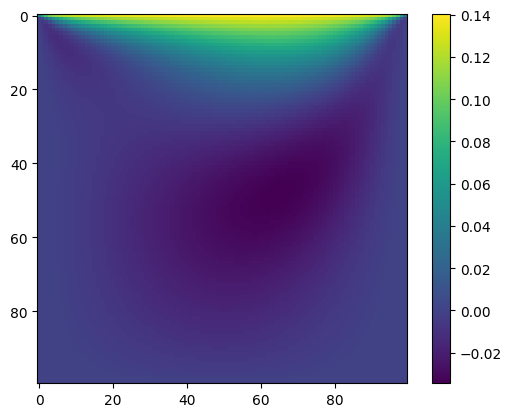

In [6]:
plt.imshow(solution[-1, 1])
plt.colorbar()

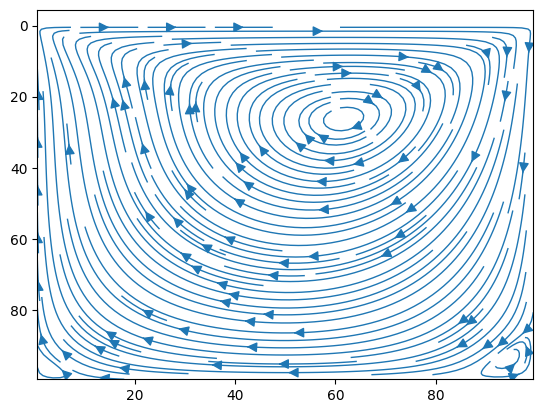

In [7]:
sol_u = solution[:, 1]
sol_v = solution[:, 2]


plt.streamplot(X, Y, sol_u[-1], sol_v[-1], density=2, linewidth=1, arrowsize=1.5)
plt.gca().invert_yaxis()
plt.show()

In [8]:
# the next few cells compare our u and v velocities with those of Ghia 1982

import pandas as pd

# data preprocessing for u-velocity
data_u_velocity = {
    "y": [1.0000, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516, 0.7344, 0.6172, 0.5000, 0.4531, 0.2813, 0.1719, 0.1016, 0.0703, 0.0625, 0.0547, 0.0000],
    "re=100": [1.0000, 0.84123, 0.78871, 0.73722, 0.68717, 0.23151, 0.00332, -0.13641, -0.20581, -0.21090, -0.15662, -0.10150, -0.06434, -0.04775,
          -0.04192, -0.03717, 0.0000],
    "re=400": [1.0000, 0.75837, 0.68439, 0.61756, 0.55892, 0.29093, 0.16256, 0.02135, -0.11477, -0.17119, -0.32726, -0.24299, -0.14612, -0.10338,
          -0.09266, -0.08186, 0.0000],
    "re=1000": [1.0000, 0.65928, 0.57492, 0.51117, 0.46604, 0.33304, 0.18719, 0.05702, -0.06080, -0.10648, -0.27805, -0.38289, -0.29730, -0.22270,
           -0.20196, -0.18109, 0.0000],
    "re=3200": [1.0000, 0.53236, 0.48269, 0.46547, 0.46101, 0.34682, 0.19791, 0.07156, -0.04272, -0.86636, -0.24427, -0.34323, -0.41933, -0.37887,
           -0.35344, -0.32407, 0.0000],
    "re=5000": [1.0000, 0.48223, 0.46120, 0.45992, 0.46036, 0.33556, 0.20087, 0.08183, -0.03039, -0.07404, -0.22855, -0.33050, -0.40435, -0.43643,
           -0.42901, -0.41165, 0.0000],
    "re=7500": [1.0000, 0.47244, 0.47048, 0.47323, 0.47167, 0.34228, 0.20591, 0.08342, -0.03800, -0.07503, -0.23176, -0.32933, -0.38324, -0.43025,
           -0.43599, -0.43154, 0.0000],
    "re=10000": [1.0000, 0.47221, 0.47783, 0.48070, 0.47804, 0.34653, 0.20673, 0.08344, 0.03111, -0.07540, -0.23186, -0.32709, -0.38000, -0.45137,
            -0.42537, -0.42735, 0.0000]
}
df_u_velocity = pd.DataFrame(data_u_velocity)
df_u_velocity.set_index('y', inplace=True)

def plot_u(reynolds):
  # Plotting
  plt.figure(figsize=(8,6))

  plt.plot(df_u_velocity[f're={reynolds}'].values, df_u_velocity.index.values, 'o', label=f're={reynolds}-Ghia-1982')
  u_velocities=sol_u[-1]/u_max
  plt.plot(u_velocities[:, int(Nx/2)], np.flip(y/Ny), label=f're={reynolds} our solution')

  plt.xlabel('u-velocity')
  plt.ylabel('y')
  plt.title('u-velocity for different y and Re')
  plt.legend()
  plt.gca().invert_yaxis()  # To invert y-axis
  plt.grid(True)

  plt.savefig(f'u_velocity_re{reynolds}', dpi=1200)

  plt.show()

In [9]:
# data preprocessing for v-velocity
data_v_velocity = {
    "x": [1.0000, 0.9688, 0.9609, 0.9531, 0.9453, 0.9063, 0.8594, 0.8047, 0.5000, 0.2344, 0.2266, 0.1563, 0.0938, 0.0781, 0.0703, 0.0625, 0.0000],
    "re=100": [0.00000, -0.05906, -0.07391, -0.08864, -0.10313, -0.16914, -0.22445, -0.24533, 0.05454, 0.17527, 0.17507, 0.16077, 0.12317, 0.10890,
               0.10091, 0.09233, 0.00000],
    "re=400": [0.00000, -0.12146, -0.15663, -0.19254, -0.22847, -0.23827, -0.44993, -0.38598, 0.05186, 0.30174, 0.30203, 0.28124, 0.22965, 0.20920,
               0.19713, 0.18360, 0.00000],
    "re=1000": [0.00000, -0.21388, -0.27669, -0.33714, -0.39188, -0.51550, -0.42665, -0.31966, 0.02526, 0.32235, 0.33075, 0.37095, 0.32627, 0.30353,
                0.29012, 0.27485, 0.00000],
    "re=3200": [0.00000, -0.39017, -0.47425, -0.52357, -0.54053, -0.44307, -0.37401, -0.31184, 0.00999, 0.28188, 0.29030, 0.37119, 0.42768, 0.41906,
                0.40917, 0.39560, 0.00000],
    "re=5000": [0.00000, -0.49774, -0.55069, -0.55408, -0.52876, -0.41442, -0.36214, -0.30018, 0.00945, 0.27280, 0.28066, 0.35366, 0.42951, 0.43648,
                0.43329, 0.42447, 0.00000],
    "re=7500": [0.00000, -0.53858, -0.55216, -0.52347, -0.48590, -0.41050, -0.36213, -0.30448, 0.00824, 0.27348, 0.28117, 0.35060, 0.41824, 0.43564,
                0.44030, 0.43979, 0.00000],
    "re=10000": [0.00000, -0.54302, -0.52987, -0.49099, -0.45863, -0.41496, -0.36737, -0.30719, 0.00831, 0.27224, 0.28003, 0.35070, 0.41847, 0.41487,
                 0.43733, 0.43983, 0.00000]
}
df_v_velocity = pd.DataFrame(data_v_velocity)
df_v_velocity.set_index('x', inplace=True)


def plot_v(reynolds):
  # Plotting
  plt.figure(figsize=(8,6))

  plt.plot(df_v_velocity[f're={reynolds}'].values, df_v_velocity.index.values, 'o', label=f're={reynolds}-Ghia-1982')
  v_velocities=sol_v[-1]/u_max
  plt.plot(-v_velocities[int(Ny/2), :], x/Nx, label=f're={reynolds} our solution')

  plt.xlabel('v-velocity')
  plt.ylabel('x')
  plt.title('v-velocity for different x and Re')
  plt.legend()
  plt.gca().invert_yaxis()  # To invert y-axis
  plt.grid(True)
  plt.savefig(f'v_velocity_re{reynolds}', dpi=1200)


  plt.show()

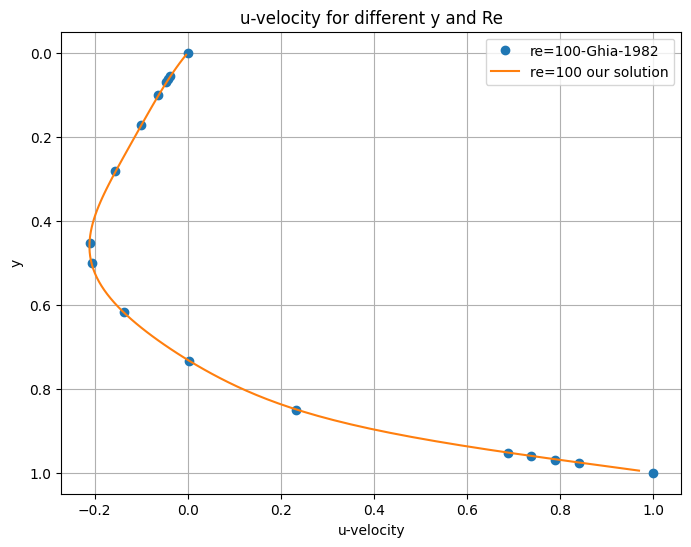

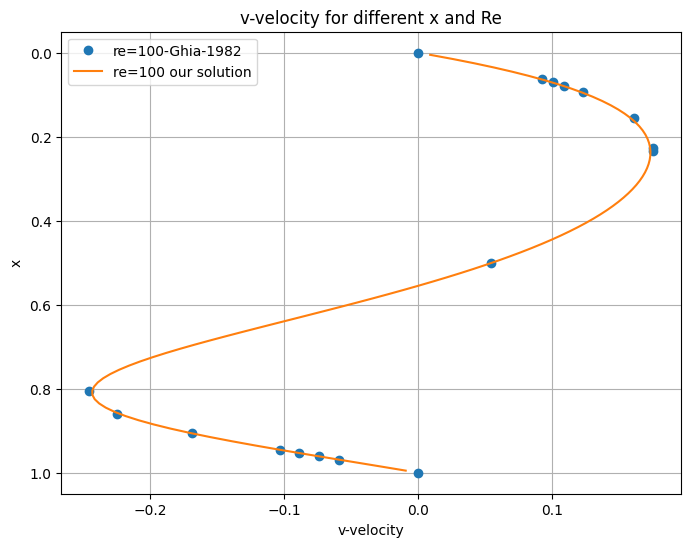

In [10]:
plot_u(100)
plot_v(100)

In [11]:
#magnitude = np.sqrt(solution[:, 1]**2 + solution[:, 2]**2)

#fig, ax = plt.subplots()
#im = ax.imshow(magnitude[0], animated=True)

#skip = 50

def get_frame(frame):
    data = magnitude[skip*frame]
    im.set_array(data)
    im.set_clim(vmin=data.min(), vmax=data.max())
    return [im]

#ani = FuncAnimation(fig, get_frame, frames=199, interval=1, blit=True)


#plt.close(fig)
#HTML(ani.to_jshtml())